# Experiment with nutpie mass matrix adaptation extended to normalizing flows

Nutpie finds a diagonal mass matrix by minimizing the fisher divergence of the posterior and a transformed posterior:

$$
\min_\eta \int \lVert \nabla \log N(x|0, 1) - \nabla \log \left(F^*_\eta \pi\right)(x) \rVert^2 d\left(F^*_\eta \pi\right)(x)
$$

where $F$ is a family of diffeomorphisms parametrized by $\eta$ and $\pi$ is the posterior density, and $\left(F^*_\eta \pi\right)(x) = \pi(F^{-1}_\eta(x)) \cdot \lvert\text{det}\nabla F^{-1}_\eta(x))\rvert$ is the pullback of the posterior density along the diffeomorphism. Note that the integration (and the norm) happens in the transformed space.

If $F_\eta$ is a coordinate-wise affine function $F_\eta(x) = x \odot \eta_\sigma + \eta_\mu$, we can minimize this analytically and get $\eta_\sigma^2 = \sqrt\frac{\text{Var}[X]}{\text{Var}[\nabla \log \pi(X)]}$ and $\eta_\mu = \text{E}[X] + \eta_\sigma \odot \text{E}[\nabla \log \pi(X)]$.

But for other families of diffeomorphisms, we can do the minimization using stochastic gradient decent.

In this notebook we use a familiy of diffeomorphisms defined by a normalizing flow implemented in flowjax.

Usually, we run mass matrix adaptation in windows during tuning, but because this is not yet included into nutpie, we manually sample and update the transformation.

We start sampling with some initial mass matrix.

We take some of those samples, and find a normalizing flow that transforms the posterior into something nicer, by minimizing the fisher divergence defined above.

We then sample for some time with that new transformation, to get some new draws.

After a few iterations the sampler is capable of sampling from quite difficult posteriors.

But other than with normalizing flows in VI, we still have the assurances of hmc/nuts that the samples are actually from the posterior, and diagnostics to figure out problems.

### Problems I see with this so far:

- The optimization can be unreliable. If we want to put something like this into nutpie, it would have to optimizie the normalizing flow without user intervention, and often the optimization only works properly if you change for instance the learning rate or the batch size.
- The fisher divergence restrictes us in the choice of normalizing flows, because the fisher divergence needs efficient forward and backward transformations and jacobian deteminants. Some normalizing flow architectures don't give us that.
- It seems training the neural networks often requires quite a few draws from the posterior, definetly often more than the diagonal mass matrix adaptation. So just 1000 tuning steps might not be enough for non-trivial cases? Perhaps it might be possible to use the full trajectories however, that would give us more training draws, and maybe even work better?
- Not a problem but a random idea: We are pretty close to computing estimators of the fisher information metric on the parameters. Could we use that during the optimization?

# Define model

As a test case we use a model with a 100 dimensional funnel, that also has some correlations.
Nuts based on diagonal mass matrix adaptation can not sample from this at all, as can be seen from the bad effective sample sizes.

In [1]:
import os
%env XLA_FLAGS=--xla_gpu_cuda_data_dir={os.environ['CONDA_PREFIX']}

import jax
import flowjax
import nutpie
import pymc as pm
import seaborn as sns
import flowjax.distributions
import flowjax.flows
import jax.numpy as jnp
import equinox as eqx
import flowjax.train
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz
from scipy import linalg
import dataclasses

jax.config.update("jax_enable_x64", True)

with pm.Model() as model:
    mu = pm.Normal("mu", sigma=1)
    log_sigma = pm.Normal("log_sigma", sigma=0.5)
    sigma = pt.exp(log_sigma)
    pm.Normal("b", sigma=sigma, mu=mu, shape=100)

# Use the jax backend so that we can more easily integrate it with flowjax.
compiled = nutpie.compile_pymc_model(model, backend="jax", gradient_backend="jax")

trace = nutpie.sample(
    compiled,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    seed=123,
)

env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/home/adr/.cache/rattler/cache/envs/flow-experiment-17471942013543406247/envs/default


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.43,15
,1300,0,0.26,15
,1300,21,0.32,7
,1300,0,0.45,15
,1300,0,0.34,7


In [2]:
def extract_points(trace):
    draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])
    return jnp.transpose(jnp.array([draws, grads]), [2, 0, 1]), draws.values.T, grads.values.T

points, draws, grads = extract_points(trace)

In [3]:
arviz.ess(trace).min().to_pandas()

b            66.136590
log_sigma    56.838133
mu           32.673229
dtype: float64

The effective sample sizes are very small, and the sampler clearly did not converge properly.

# Set up a normalizing flow

We set up a small normalizing flow as familiy of diffeomorphisms $F$.
We use a coupling_flow, because this one has good peroformance for both the transform and the inverse transform. We also add a affine layer with the results from the diagonal mass matrix adaptation, to nudge it into the correct region and avoid numerical trouble.

For comparison we also set up two purely affine transformations.

In [4]:
key = jax.random.PRNGKey(0)

diag = np.sqrt(draws.std(0) / grads.std(0))
mean = draws.mean(0) + diag * grads.mean(0)

diag50 = np.sqrt(draws[:50].std(0) / grads[:50].std(0))
mean50 = draws[:50].mean(0) + diag50 * grads[:50].mean(0)

flow_key, key = jax.random.split(key)
base_dist = flowjax.distributions.Normal(jnp.zeros(compiled.n_dim))
flow_templ = flowjax.flows.coupling_flow(
    flow_key,
    base_dist=base_dist,
    invert=True,
    nn_activation=jax.nn.gelu,
)
flow = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flow_templ.bijection,
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

flow_diag = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean, scale=diag),
    ]),
)

flow_diag50 = flowjax.flows.Transformed(
    base_dist,
    flowjax.flows.Chain([
        flowjax.flows.Affine(loc=mean50, scale=diag50),
    ]),
)

# Run VI just for comparison

We can also minimize the elbo to approximate the posterior.
At least the way I'm doing it here this does require quite a lot
of logp evaluations however, and also doesn't seem to fit the posterior
all too well.

In [5]:
# Some ugly gymnastics to get the logp function from nutpie...
logp_fn_ = compiled._make_logp_func().__closure__[0].cell_contents
logp_fn = lambda x: logp_fn_._fun.__closure__[1].cell_contents(x)[0]

In [6]:
elbo_loss = flowjax.train.losses.ElboLoss(logp_fn, num_samples=1000)

key, train_key = jax.random.split(key)

vi_fit, losses = flowjax.train.fit_to_variational_target(
    train_key, flow, elbo_loss, learning_rate=1e-3, steps=3000,
)

100%|██████████| 3000/3000 [00:57<00:00, 52.39it/s, loss=0.185]


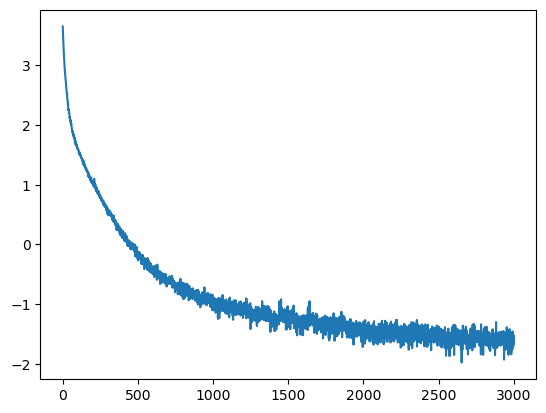

In [7]:
plt.plot(np.log(losses))

## Some hacky code to transform nutpie models

We set up some helper functions to transform our model and the resulting draws.

In [8]:
def normalize_model(compiled_model, flow):
    logp_fn = compiled._make_logp_func().__closure__[0].cell_contents

    @jax.jit
    def trafo_logp(x):
        def inner_logp(x):
            y, logdet = flow.bijection.transform_and_log_det(x)
            logp, _ = logp_fn(y)
            return logdet + logp

        return jax.value_and_grad(inner_logp)(x)

    def logp_wrapper(x):
        logp, grad = trafo_logp(x)
        return float(logp), np.array(grad, dtype="float64", order="C")

    return dataclasses.replace(compiled, _make_logp_func=lambda: logp_wrapper)


def unnormalize_points(trace, flow):
    normalized_draws = trace.sample_stats.unconstrained_draw.stack(sample=["chain", "draw"])
    normalized_grads = trace.sample_stats.gradient.stack(sample=["chain", "draw"])

    def get_untransformed(flow, draw_trafo, grad_trafo):
        draw = flow.bijection.transform(draw_trafo)
        _, pull_grad_fn = jax.vjp(flow.bijection.inverse_and_log_det, draw)
        (grad,) = pull_grad_fn((grad_trafo, 1.))
        return draw, grad

    get_untransformed = jax.vmap(get_untransformed, [None, 0, 0])
    
    draws, grads = get_untransformed(
        flow,
        normalized_draws.values.T,
        normalized_grads.values.T,
    )
    return jnp.transpose(jnp.array([draws, grads]), [1, 0, 2]), draws, grads

In [9]:
# The fisher divergence loss
@eqx.filter_jit
def loss(flow, draw, grad):
    trafo = flow.bijection.inverse(draw)
    _, pull_grad_fn = jax.vjp(flow.bijection.transform_and_log_det, trafo)
    (grad_fit,) = pull_grad_fn((grad, 1.))

    return ((grad_fit + trafo) ** 2).sum()

In [10]:
class FisherLoss:
    @eqx.filter_jit
    def __call__(
        self,
        params,
        static,
        x,
        condition = None,
        key = None,
    ):
        flow = flowjax.train.losses.unwrap(eqx.combine(params, static))

        assert x.shape[1] == 2
        draw = x[:, 0, :]
        grad = x[:, 1, :]

        # We minimize the log of the loss. This seems to work way better,
        # I *think* because the same learning rate works for more cases.
        return jnp.log(jax.vmap(loss, [None, 0, 0])(flow, draw, grad).mean())

In [11]:
# Fisher divergence of the flow without any fitting
params, static = eqx.partition(flow, eqx.is_array)
float(FisherLoss()(params, static, points))

39.94271452714088

In [12]:
# Fisher divergence of the VI fit
params, static = eqx.partition(vi_fit, eqx.is_array)
float(FisherLoss()(params, static, points))

0.8946848524239525

In [13]:
# Fisher divergence of the nutpie diagonal mass matrix approximation
params, static = eqx.partition(flow_diag, eqx.is_array)
float(FisherLoss()(params, static, points))

5.283127813997333

In [14]:
# Fisher divergence of the nutpie diagonal mass matrix approximation with 50 draws
params, static = eqx.partition(flow_diag50, eqx.is_array)
float(FisherLoss()(params, static, points))

6.302001897782366

# First fisher divergence minimization run

We use 1000 draws from our posterior approximation to fit the normalizing flow, and keep the other draws for validation. This isn't exaclty fast, but at least it doesn't need to do any extra logp evaluations. So if the logp function is slow, this will still take the same amount of time.

In [15]:
train_key, key = jax.random.split(key)
fit, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=flow,
    x=points[:1000],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 84%|████████▎ | 167/200 [01:59<00:23,  1.40it/s, train=-0.554370231299862, val=0.46720340107117403 (Max patience reached)]


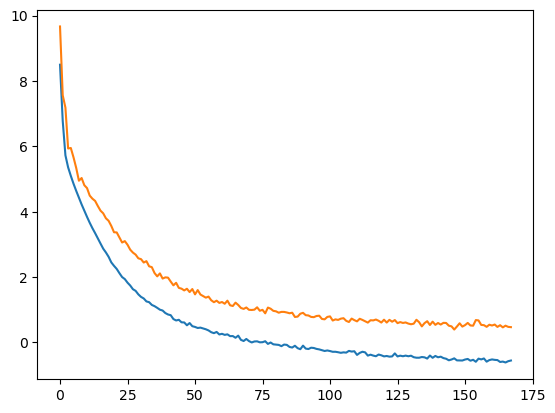

In [16]:
plt.plot(np.array(data["train"]))
plt.plot(np.array(data["val"]))

In [17]:
# Fisher divergence of the fit on the validation dataset
params, static = eqx.partition(fit, eqx.is_array)
float(FisherLoss()(params, static, points[1000:]))

1.0218557764235654

In [18]:
# Elbo loss of the fit
elbo_loss(params, static, key)

Array(0.38567539, dtype=float64)

## Some plots about the fit

We can now sample from the normal distribution on the transformed space, and
transform those draws with our learned transformation. Ideally, they look similar to the posterior.

In [19]:
sample_key, key = jax.random.split(key)
samples = fit.sample(sample_key, (6000,))

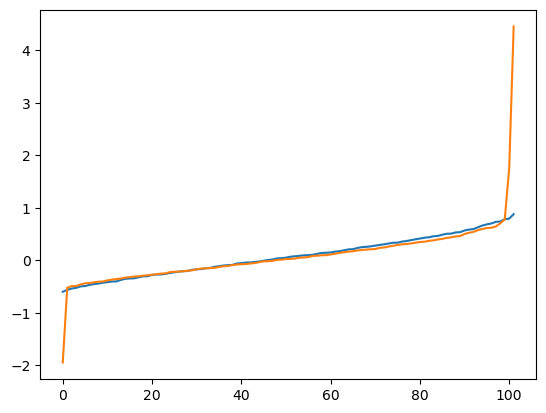

In [20]:
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.cov(samples.T))))
plt.plot(np.log(linalg.eigvalsh(np.cov(draws.T), np.diag(diag ** 2))))

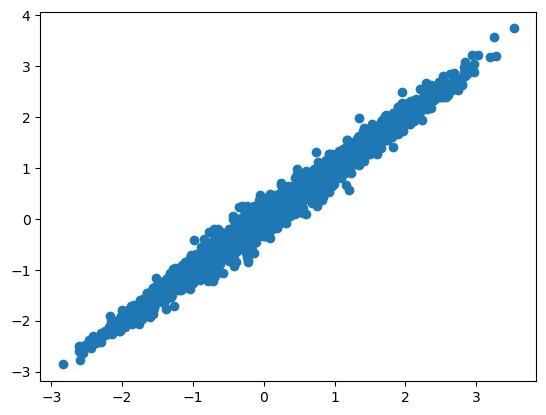

In [21]:
plt.scatter(draws[:, 0], draws[:, 2:].mean(1))

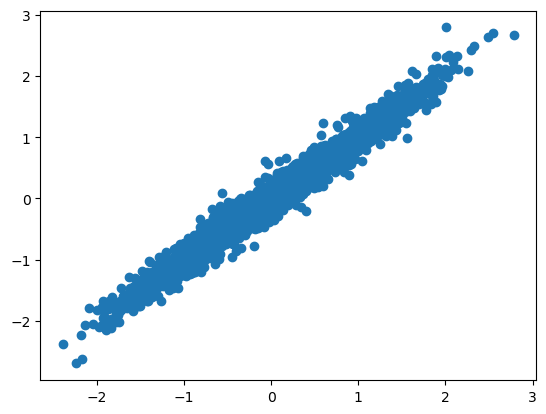

In [22]:
plt.scatter(samples[:, 0], samples[:, 2:].mean(1))

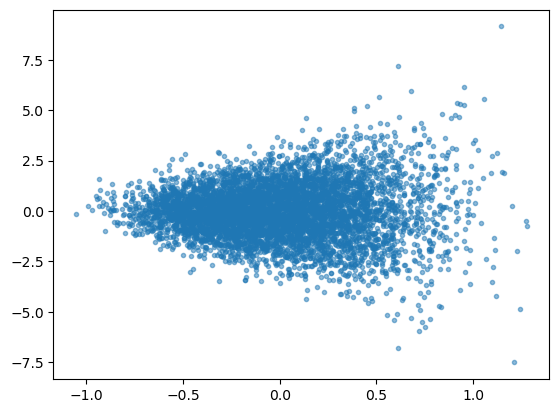

In [23]:
i = 1
j = -1
plt.scatter(samples[:, i], samples[:, j], alpha=0.5, marker=".")
#plt.scatter(draws[i], draws[j], alpha=0.5, marker=".")
#plt.xlim((-40, 40))

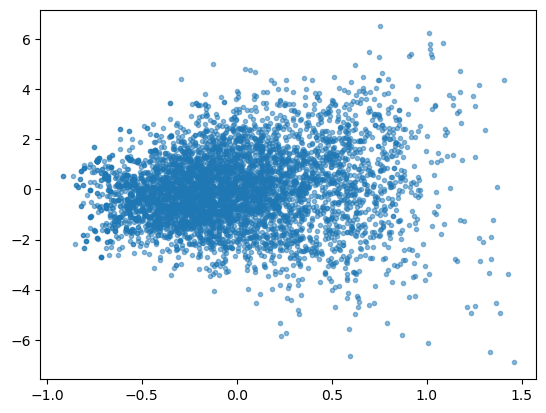

In [24]:
plt.scatter(draws[:, i], draws[:, j], alpha=0.5, marker=".")

We can also transform our (bad) posterior draws and see how well they seem to fit a standard normal distribution

In [25]:
draws_trafo = jax.vmap(fit.bijection.inverse, in_axes=[0])(draws)

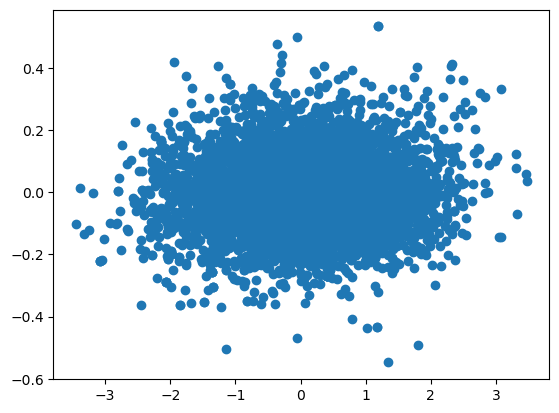

In [26]:
plt.scatter(draws_trafo[:, 0], draws_trafo[:, 1:].mean(1))

<Axes: ylabel='Density'>

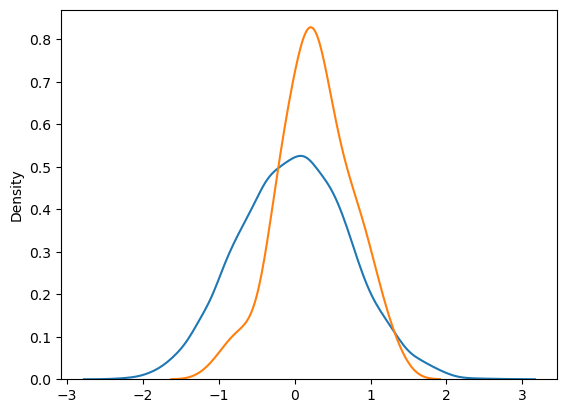

In [27]:
sns.kdeplot(samples[:, 0])
sns.kdeplot(draws[0])

# Sample again, but now in the transformed space that we just learned.

In [28]:
compiled2 = normalize_model(compiled, fit)

In [29]:
trace2 = nutpie.sample(
    compiled2,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=1234,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.48,7
,1300,0,0.49,7
,1300,0,0.49,7
,1300,0,0.52,7
,1300,0,0.51,7


In [30]:
arviz.ess(trace2.sample_stats.unconstrained_draw).min().to_pandas()

unconstrained_draw    1872.337022
dtype: float64

# Repeat the fit and sample once more

The sampler is already mostly fine, but we can repeat this again to get a better fit

In [31]:
points2, draws2, grads2 = unnormalize_points(trace2, fit)

In [32]:
fit2, data = flowjax.train.fit_to_data(
    key=train_key,
    dist=fit,
    x=points2[:1000],
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=200,
    max_patience=20,
    loss_fn=FisherLoss(),
)

 40%|████      | 80/200 [00:55<01:23,  1.44it/s, train=-0.3503421041640474, val=0.37706596529447806 (Max patience reached)]


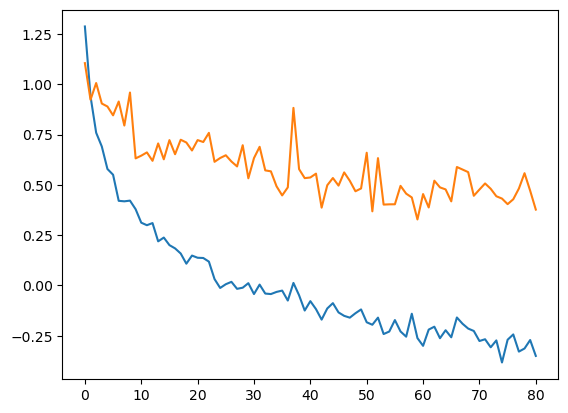

In [33]:
plt.plot(data["train"])
plt.plot(data["val"])

In [34]:
params, static = eqx.partition(fit, eqx.is_array)
FisherLoss()(params, static, points2[1000:])

Array(1.8035712, dtype=float64)

In [35]:
params, static = eqx.partition(fit2, eqx.is_array)
FisherLoss()(params, static, points2[1000:])

Array(0.64876358, dtype=float64)

In [36]:
compiled3 = normalize_model(compiled, fit2)

trace3 = nutpie.sample(
    compiled3,
    chains=5,
    store_gradient=True,
    store_unconstrained=True,
    store_mass_matrix=True,
    seed=123456,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.53,7
,1300,0,0.51,7
,1300,0,0.51,7
,1300,0,0.51,7
,1300,0,0.52,7


In [37]:
arviz.ess(trace3.sample_stats.unconstrained_draw).min().unconstrained_draw.values

array(4429.39773965)